# CELL NUCLEI DETECTION USING IMAGE SEGMENTATION WITH U-NET

In [67]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-9v65iz81
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-9v65iz81


In [68]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from scipy import io
import os

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
%cd /MyDrive/cell_data/

!unzip "/content/gdrive/MyDrive/cell_data/data-science-bowl-2018.zip" -d "/content/gdrive/MyDrive/cell_data/dataset"

In [73]:
# 1. Data loading
# 1.1 Prepare a list for image and and mask in train set
train_images=[]
train_masks=[]
train_directory = r'/content/gdrive/MyDrive/cell_data/dataset/data-science-bowl-2018-2/train'

In [74]:
# 1.2 Prepare a list for image and and mask in test set
test_images=[]
test_masks=[]
test_directory = r'/content/gdrive/MyDrive/cell_data/dataset/data-science-bowl-2018-2/test'

In [75]:
# 1.3 Load the images in train set
image_dir = os.path.join(train_directory, 'inputs')
for image_file in os.listdir(image_dir):
  img = cv2.imread(os.path.join(image_dir, image_file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(128,128))
  train_images.append(img)

# 1.4 Load the masks in train set
mask_dir = os.path.join(train_directory,'masks')
for mask_file in os.listdir(mask_dir):
  mask = cv2.imread(os.path.join(mask_dir, mask_file),cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask,(128,128))
  train_masks.append(mask)

In [76]:
# 1.5 Load the images in test set
image_dir = os.path.join(test_directory, 'inputs')
for image_file in os.listdir(image_dir):
  img = cv2.imread(os.path.join(image_dir, image_file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(128,128))
  test_images.append(img)

# 1.6 Load the masks in test set
mask_dir = os.path.join(test_directory,'masks')
for mask_file in os.listdir(mask_dir):
  mask = cv2.imread(os.path.join(mask_dir, mask_file),cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask,(128,128))
  test_masks.append(mask)

In [77]:
# 1.7 Convert images and masks for train set into numpy array
train_images_np = np.array(train_images)
train_masks_np = np.array(train_masks)

In [78]:
# check the shape of numpy array for test set
train_images_np.shape

(603, 128, 128, 3)

In [79]:
# 1.8 Convert images and masks for test set into numpy array
test_images_np = np.array(test_images)
test_masks_np = np.array(test_masks)

In [80]:
# check the shape of numpy array for test set
test_images_np.shape

(67, 128, 128, 3)

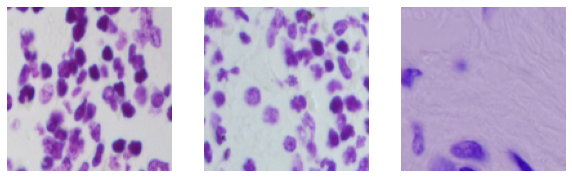

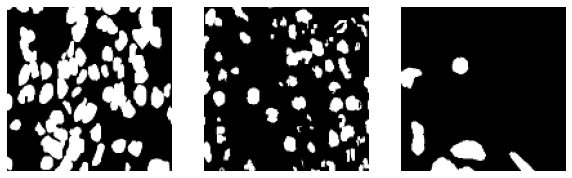

In [81]:
# 1.9 Check some examples
plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  img_plot = train_images[i]
  plt.imshow(img_plot)
  plt.axis('off')
plt.show()

plt.figure(figsize=(10,4))
for i in range(1,4):
  plt.subplot(1,3,i)
  mask_plot = train_masks[i]
  plt.imshow(mask_plot, cmap='gray') 
  plt.axis('off')
plt.show()

In [82]:
# 2. Data preprocessing
# 2.1 Expand the mask dimension for train set
train_masks_np_exp = np.expand_dims(train_masks_np, axis=-1)
#check the mask output
print(train_masks[0].min(),train_masks[0].max())

0 255


In [83]:
# 2.2 Expand the mask dimension for test set
test_masks_np_exp = np.expand_dims(test_masks_np, axis=-1)
print(test_masks[0].min(),test_masks[0].max())

0 255


In [84]:
# 2.3 Change the mask value (1. normalize the value, 2. encode into numerical encoding)
train_converted_masks = np.ceil(train_masks_np_exp/255)
train_converted_masks = 1-train_converted_masks

In [85]:
# 2.4 Expand the mask dimension for test set
test_converted_masks = np.ceil(test_masks_np_exp/255)
test_converted_masks = 1-test_converted_masks

In [86]:
# 2.5 Normalize the images
train_converted_images = train_images_np/255.0

In [87]:
test_converted_images = test_images_np/255.0

In [88]:
# 2.4 Do train-test split
from sklearn.model_selection import train_test_split

SEED=12345
x_train, x_val,y_train, y_val = train_test_split(train_converted_images,train_converted_masks, test_size=0.2, random_state=SEED)

In [89]:
# 2.6 Convert the numpy array data into tensor slice

train_x = tf.data.Dataset.from_tensor_slices(x_train)
test_x = tf.data.Dataset.from_tensor_slices(test_converted_images)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
test_y = tf.data.Dataset.from_tensor_slices(test_converted_masks)
val_x = tf.data.Dataset.from_tensor_slices(x_val)
val_y = tf.data.Dataset.from_tensor_slices(y_val)

In [90]:
# 2.7 Zip tensor slice into dataset
train = tf.data.Dataset.zip((train_x,train_y))
test = tf.data.Dataset.zip((test_x,test_y))
val = tf.data.Dataset.zip((val_x,val_y))

In [91]:
# 2.8 Convert into prefetch dataset
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 800//BATCH_SIZE
VALIDATION_STEP = 200//BATCH_SIZE
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train = train.prefetch(buffer_size=AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val = val.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val = val.prefetch(buffer_size=AUTOTUNE)

In [92]:
# 3. Prepare model
# We are going to create a modified version of U-Net
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [93]:
#Define the upsampling stack
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [94]:
#Function to create the entire modified U-net
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [95]:
#Define the model
OUTPUT_CLASSES = 2
model = unet_model(output_channels=OUTPUT_CLASSES)

In [96]:
#%%
#Compile the model and display the model structure
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_2[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

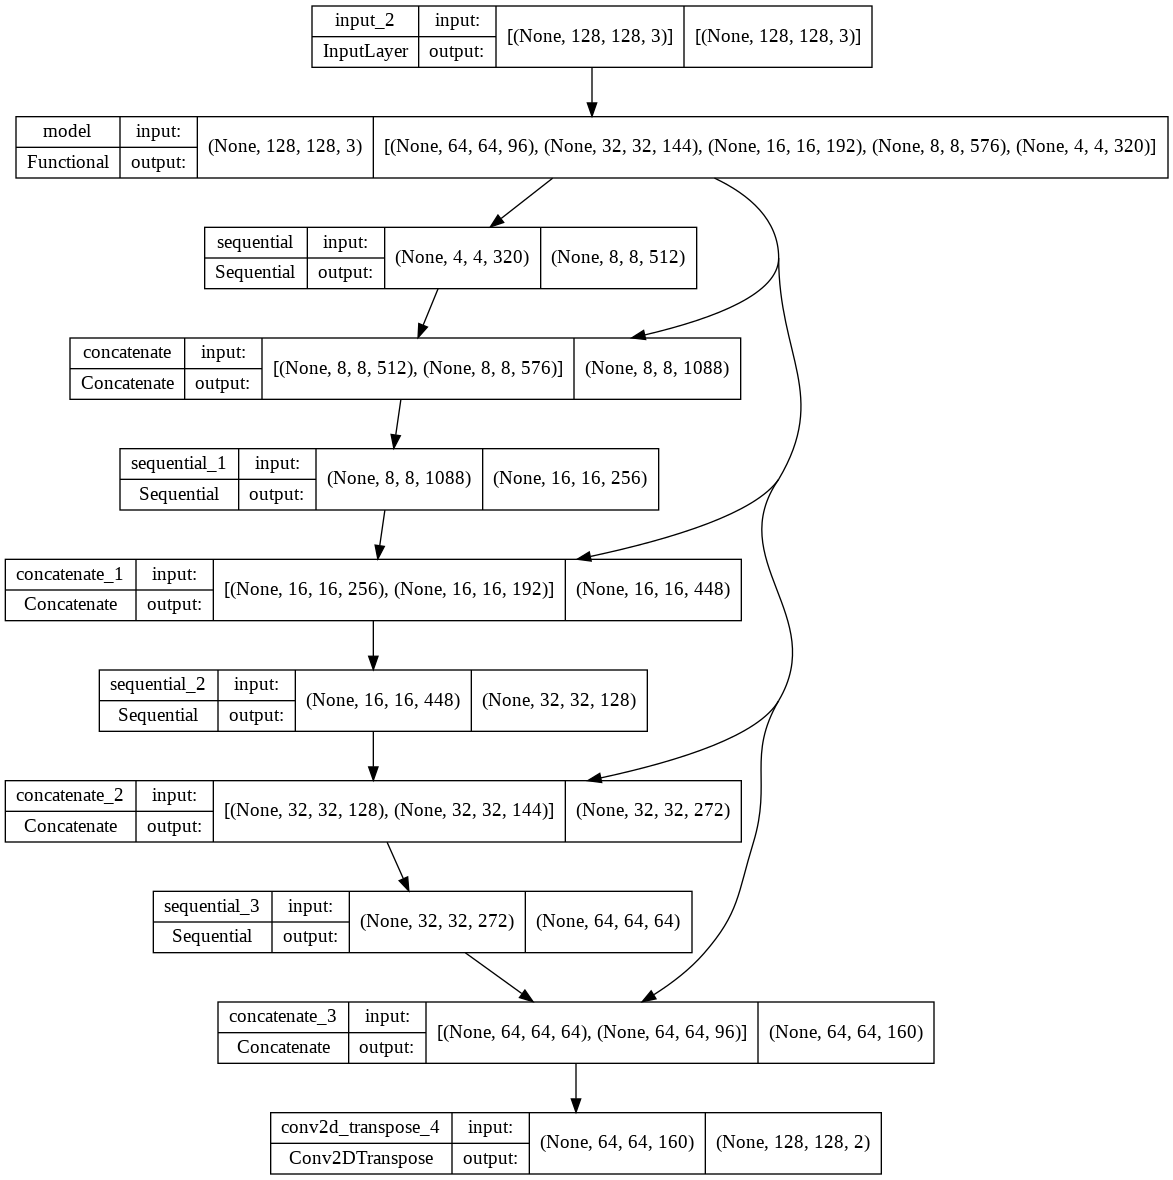

In [97]:
tf.keras.utils.plot_model(model, show_shapes=True)

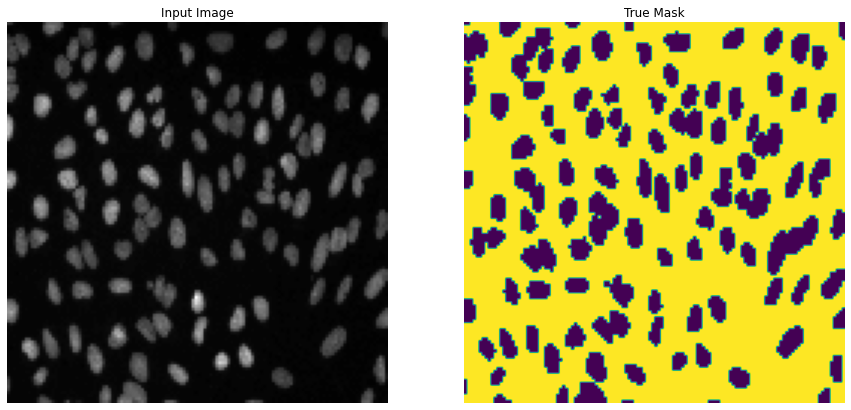

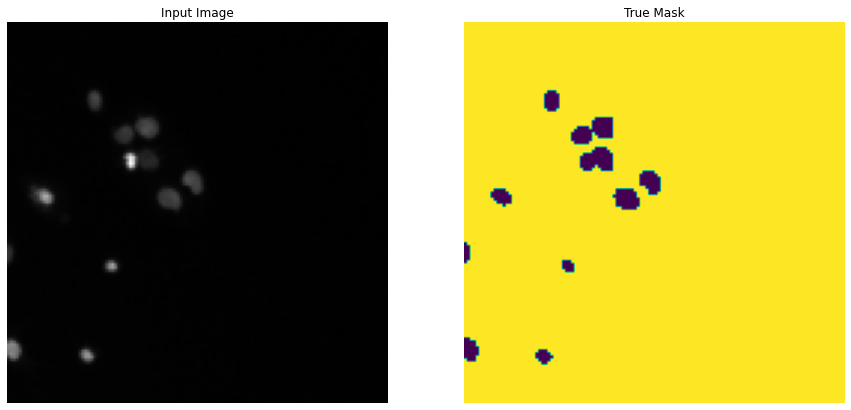

In [98]:
#Create a function to display some examples
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image','True Mask','Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list),i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()
    
for train_images, train_masks in train.take(2):
    sample_image, sample_mask = train_images[0], train_masks[0]
    display([sample_image,sample_mask])

In [99]:
# Create a function to process predicted mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [100]:
# Create a function to display prediction
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [101]:
#Custom callback to display result during training
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\n Sample prediction after epoch {}\n'.format(epoch+1))

In [102]:
tf.keras.backend.clear_session()

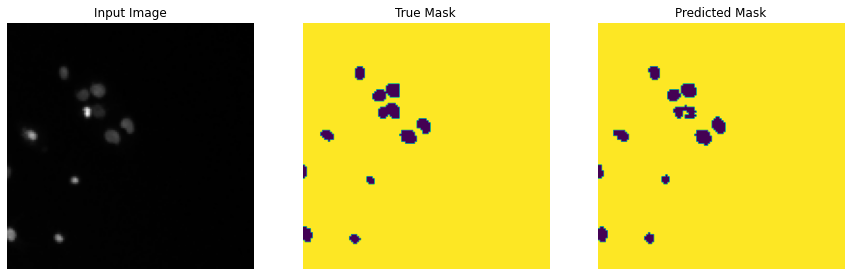


 Sample prediction after epoch 30

50/50 [==============================] - 8s 171ms/step - loss: 0.0496 - accuracy: 0.9796 - val_loss: 0.0955 - val_accuracy: 0.9649


In [103]:
# Training 
import datetime, os
EPOCH = 30

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train,epochs=EPOCH,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEP,
                    validation_data=val,
                    callbacks=[DisplayCallback(), tb_callback])

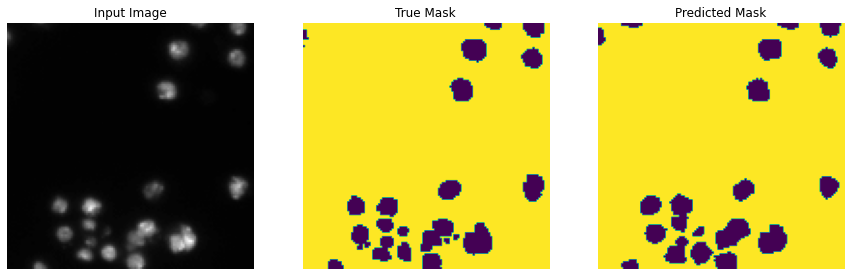

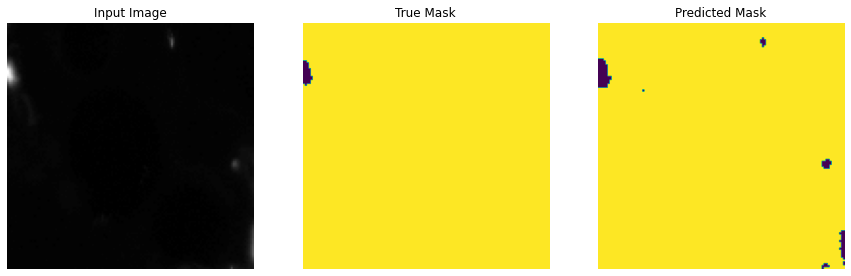

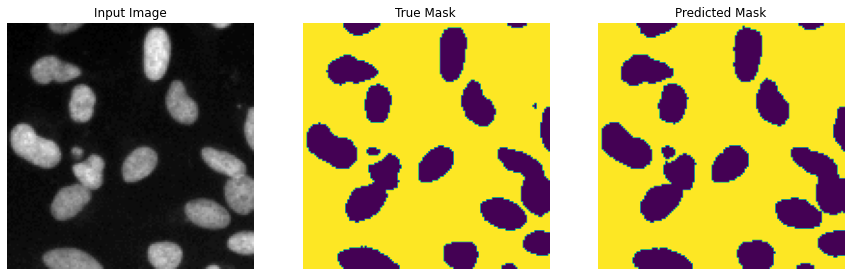

In [104]:
show_predictions(test,3)

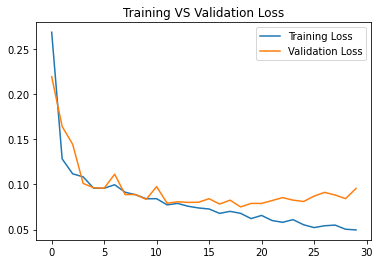

<Figure size 432x288 with 0 Axes>

In [105]:
training_loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs = history.epoch

plt.plot(epochs, training_loss, label ='Training Loss')
plt.plot(epochs, val_loss, label ='Validation Loss')
plt.title('Training VS Validation Loss')
plt.legend()
plt.figure()
plt.show()

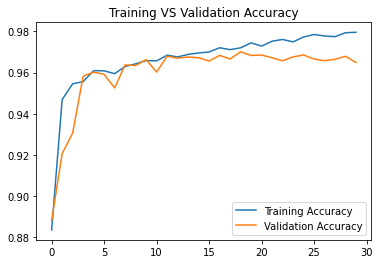

<Figure size 432x288 with 0 Axes>

In [109]:
training_accuracy = history.history['accuracy'] 
val_accuracy = history.history['val_accuracy'] 
epochs = history.epoch

plt.plot(epochs, training_accuracy, label ='Training Accuracy')
plt.plot(epochs, val_accuracy, label ='Validation Accuracy')
plt.title('Training VS Validation Accuracy')
plt.legend()
plt.figure()
plt.show()

In [111]:
# Obtain accuracy and lost on test set
score = model.evaluate(test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 47ms/step - loss: 0.1014 - accuracy: 0.9627
Test loss: 0.10135713964700699
Test accuracy: 0.9627130031585693
